<a href="https://colab.research.google.com/github/IagoGarciaSuarez/MachineLearningNLP/blob/main/ML_Task_3_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Getting Ready

In [ ]:
!rm *.csv
!wget https://raw.githubusercontent.com/IagoGarciaSuarez/MachineLearningNLP/main/comments_targetdata.csv

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('popular')
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn import model_selection, svm

In [28]:
comments = pd.read_csv("comments_targetdata.csv")
comments.drop(['Unnamed: 0'], axis=1, inplace=True)
comments

,class,text,transf_text
0,auto,i have recently purchased a j30t with moderat...,recently purchase moderate miles stop car look...
1,camera,i bought this product because i need instant ...,buy product need instant gratification stand t...
2,auto,i have owned my buick since 53000 km and i am...,own quick since km approach must say nicest ca...
3,camera,this was my first digital camera so i did qui...,first digital camera quite bite research unfor...
4,camera,minolta dimage 7hi is in a digital slr with 5...,minorca damage hi digital sir megapixel cod se...
...,...,...,...
595,auto,recently our 12 year old nissan stanza decide...,recently year old nissan stanza decide time re...
596,camera,i always do a lot of research before i buy an...,always lot research buy anything anymore talk ...
597,auto,this car is an all around good buy if you ar...,car around good buy cars really get lot extra ...
598,auto,i waited to write this until i have had 4 mon...,wait write months drive kit shortage wife hand...


# 2. Vectorization

## 2.1. TFIDF

TF-IDF is applied to the dataset in order to get term frequency for each occurrence.

In [29]:
vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)
data = vectorizer.fit_transform(comments['transf_text'])
comments_tfidf = pd.DataFrame(data.toarray(), columns=vectorizer.get_feature_names())
comments_tfidf

,abandon,abbreviations,aberration,aberrations,abilities,ability,able,abound,abrade,abreast,abroad,absence,absent,absolute,absolutely,absorb,abstract,abundance,abundant,abundantly,abuse,abysmally,ac,acacia,acccspw,accelerate,acceleration,accelerations,accent,accept,acceptable,accesories,access,accessible,accessories,accessory,accident,accidental,accidentally,accidently,...,wristband,wriststrap,write,writer,wrong,www,wysiwyg,xx,yahoos,yakov,yankee,yard,yards,yashica,yeah,year,yearly,years,yell,yellow,yellowish,yep,yes,yesterday,yesteryear,yet,yiddish,yield,yokohama,york,young,younger,youth,youthful,zealand,zero,ziebart,zip,zone,zoombrowser
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.077469,0.0,0.0,0.320777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.080442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113357,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.113357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051440,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028935,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.0,0.0,0.0,0.0,0.0,0.0,0.045322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043258,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.062580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0

## 2.2. N-GRAMS

With N-Grams, a dataframe with n-grams with a range of 1 to 3 words is built.

In [30]:
vectorizer = TfidfVectorizer(ngram_range=(1,3))
data = vectorizer.fit_transform(comments['transf_text'])

comments_ngrams = pd.DataFrame(data.toarray(), columns=vectorizer.get_feature_names())
comments_ngrams

,abandon,abandon acute,abandon acute respect,abbreviations,abbreviations charge,abbreviations charge couple,abbreviations international,abbreviations international standardization,abbreviations liquid,abbreviations liquid crystal,abbreviations rather,abbreviations rather clearly,aberration,aberration could,aberration could possibly,aberration high,aberration high contrast,aberration purple,aberration purple bring,aberration visible,aberration visible maximum,aberrations,aberrations magnify,aberrations magnify many,abilities,abilities another,abilities another option,abilities camera,abilities camera lot,abilities come,abilities come closer,abilities one,abilities one buy,abilities red,abilities red eye,ability,ability accurately,ability accurately frame,ability add,ability add attachment,...,zip first,zip first get,zip fruitlowsharp,zip fruitlowsharp pg,zip fruitneutral,zip fruitneutral pg,zip fruitoff,zip fruitoff pg,zip fruitvivid,zip fruitvivid pg,zip gallery,zip gallery dandenongrangesflower,zip gallery greatoceanroadgrotto,zip gallery greatoceanroadlookout,zip gallery greatoceanroadthe,zip gunnoise,zip gunnoise pg,zip happy,zip happy daysold,zip keyboard,zip keyboard pg,zip northbalwyneasternfreeway,zip northbalwyneasternfreeway pg,zip northbalwynmumspetunas,zip northbalwynmumspetunas pg,zip rspcapixelation,zip rspcapixelation pg,zip thetwelveapostles,zip thetwelveapostles septa,zone,zone around,zone around rum,zone modes,zone modes pan,zoombrowser,zoombrowser ex,zoombrowser ex imagebrowser,zoombrowser ex program,zoombrowser software,zoombrowser software include
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

## 2.3. POS tagging

After detecting all the word types found in every comment, a column will be added for each one with the value of the number of occurrences found per type.

In [31]:
pos_tags = []
tags_count = []
tags_rows = []
for com in comments['transf_text']:
  com_tokens = word_tokenize(com)
  c = dict(Counter([j for i,j in nltk.pos_tag(com_tokens)]))
  tags_count.append(c)
  pos_tags = list(set(pos_tags + list(c.keys())))

for tags_dict in tags_count:
  t = []
  for tag in pos_tags:
    if tag in tags_dict:
      t.append(tags_dict[tag])
    else:
      t.append(0)
  tags_rows.append(t)

comments[pos_tags] = tags_rows
comments.head()

,class,text,transf_text,VBD,EX,FW,VBG,VB,RBS,WDT,CC,IN,NN,TO,VBP,NNS,VBN,VBZ,MD,WRB,CD,JJ,NNP,JJR,DT,WP,NNPS,RBR,RP,UH,PDT,RB,PRP,JJS,PRP$,WP$
0,auto,i have recently purchased a j30t with moderat...,recently purchase moderate miles stop car look...,0,0,0,0,1,0,0,0,2,47,0,9,6,0,0,0,0,0,28,0,0,1,0,0,0,0,0,0,13,0,0,0,0
1,camera,i bought this product because i need instant ...,buy product need instant gratification stand t...,3,0,0,0,19,0,0,0,8,140,0,15,7,3,1,2,0,5,53,0,3,0,0,0,0,0,0,0,8,1,0,0,0
2,auto,i have owned my buick since 53000 km and i am...,own quick since km approach must say nicest ca...,3,0,0,0,1,0,0,1,1,64,0,5,1,0,0,3,0,2,27,0,1,0,0,0,0,0,0,0,19,0,1,0,0
3,camera,this was my first digital camera so i did qui...,first digital camera quite bite research unfor...,0,0,0,0,4,0,0,0,1,34,0,11,3,0,1,1,1,2,17,0,0,0,0,0,0,0,0,0,8,0,0,0,0
4,camera,minolta dimage 7hi is in a digital slr with 5...,minorca damage hi digital sir megapixel cod se...,3,0,2,2,12,0,0,0,12,243,0,32,25,2,3,5,0,7,112,0,9,1,0,0,3,0,0,0,34,3,4,0,0


## 2.4. Other features

Number of sentences and number of words are calculated and added to the dataframe.

In [32]:
n_sentences = []
n_words = []
for com in comments['transf_text']:
  n_words.append(len(word_tokenize(com)))

for com in comments['text']:
  n_sentences.append(len(sent_tokenize(com)))

comments['n_sentences'] = n_sentences
comments['n_words'] = n_words

# 3. Feature Selection

Using the dataframe obtained from concatenating the number of sentences and number of words columns with the n-grams dataframe, there exists 252832 features, so they will be reduced to a 30% of the size.

In [33]:
X_clf=pd.concat([comments, comments_ngrams], axis=1).iloc[:,3:]
y_clf=comments['class']

X_clf

,VBD,EX,FW,VBG,VB,RBS,WDT,CC,IN,NN,TO,VBP,NNS,VBN,VBZ,MD,WRB,CD,JJ,NNP,JJR,DT,WP,NNPS,RBR,RP,UH,PDT,RB,PRP,JJS,PRP$,WP$,n_sentences,n_words,abandon,abandon acute,abandon acute respect,abbreviations,abbreviations charge,...,zip first,zip first get,zip fruitlowsharp,zip fruitlowsharp pg,zip fruitneutral,zip fruitneutral pg,zip fruitoff,zip fruitoff pg,zip fruitvivid,zip fruitvivid pg,zip gallery,zip gallery dandenongrangesflower,zip gallery greatoceanroadgrotto,zip gallery greatoceanroadlookout,zip gallery greatoceanroadthe,zip gunnoise,zip gunnoise pg,zip happy,zip happy daysold,zip keyboard,zip keyboard pg,zip northbalwyneasternfreeway,zip northbalwyneasternfreeway pg,zip northbalwynmumspetunas,zip northbalwynmumspetunas pg,zip rspcapixelation,zip rspcapixelation pg,zip thetwelveapostles,zip thetwelveapostles septa,zone,zone around,zone around rum,zone modes,zone modes pan,zoombrowser,zoombrowser ex,zoombrowser ex imagebrowser,zoombrowser ex program,zoombrowser software,zoombrowser software include
0,0,0,0,0,1,0,0,0,2,47,0,9,6,0,0,0,0,0,28,0,0,1,0,0,0,0,0,0,13,0,0,0,0,1,107,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,0,0,0,19,0,0,0,8,140,0,15,7,3,1,2,0,5,53,0,3,0,0,0,0,0,0,0,8,1,0,0,0,1,268,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,0,0,1,0,0,1,1,64,0,5,1,0,0,3,0,2,27,0,1,0,0,0,0,0,0,0,19,0,1,0,0,1,129,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,4,0,0,0,1,34,0,11,3,0,1,1,1,2,17,0,0,0,0,0,0,0,0,0,8,0,0,0,0,1,83,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,0,2,2,12,0,0,0,12,243,0,32,25,2,3,5,0,7,112,0,9,1,0,0,3,0,0,0,34,3,4,0,0,1,514,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,9,0,0,0,4,81,0,11,9,2,0,2,0,3,56,0,1,0,0,0,0,0,0,0,15,0,0,0,0,1,193,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,1,0,0,0,14,0,0,0,4,68,0,10,7,0,0,1,0,2,31,0,0,0,0,0,0,0,0,0,14,0,1,0,0,1,153,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0,0,0,0,5,0,0,0,2,25,0,5,6,0,1,1,0,0,11,0,0,0,0,0,0,0,0,0,11,0,1,0,0,1,68,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,3,0,0,0,10,0,0,0,3,89,0,10,13,1,0,4,0,4,50,0,2,0,0,0,1,1,0,0,16,0,0,0,0,1,207,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For classification purposes, the labels "auto" and "camera" are asigned to values 1 and 2 respectively. Then, using SelectKBest algorithm, the reduction is applied using chi2.

In [34]:
y_clf = np.where(y_clf == 'auto', 1, y_clf)
y_clf = np.where(y_clf == 'camera', 2, y_clf)
y_clf = y_clf.astype('int')

k_best = SelectKBest(score_func=chi2,k=int(0.3*X_clf.shape[1]))
x_clf = k_best.fit_transform(X_clf,y_clf)

# 4. Classification

Now it's time to train the model for classification predictions. The dataframe is divided into training set and test set, and Support Vector Machines is used over the training set.

Once the model is ready, it is used over the test set to predict the results.

In [35]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_clf, y_clf, test_size=0.3, shuffle=True)

SVM = svm.SVC(kernel='linear')
SVM.fit(X_train,y_train)

resultado = SVM.predict(X_test)

To verify the results, a confusion matrix is displayed.

The accuracy is +99.44%, therefore results can be considered successful.

Predicted values (Accuracy = 99.4444%)


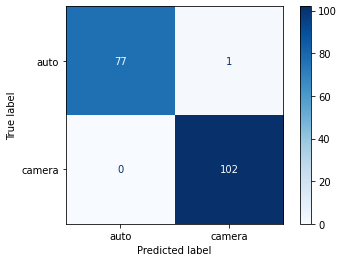

In [36]:
print("Predicted values (Accuracy = {:.4f}%)".format(accuracy_score(y_test, resultado)*100))
disp = plot_confusion_matrix(SVM, X_test, y_test, display_labels=["auto", "camera"], cmap=plt.cm.Blues) 
plt.show()